In [1]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
import numpy as np

import matplotlib.pyplot as plt
from time import time
from scipy.stats import randint as sp_randint
import seaborn as sns
sns.set_context('talk')
figsave = False

In [4]:

# Utility function to report best scores
def print_score(results, candidate):
    print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
        results['mean_test_score'][candidate],
        results['std_test_score'][candidate]))
    print("Parameters: {0}".format(results['params'][candidate]))
    

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print_score(results, candidate)
            print("")

def best_score(results):
    candidate = np.flatnonzero(results['rank_test_score'] == 1)[0]
    return results['mean_test_score'][candidate]


In [5]:
housing = fetch_california_housing()
X, X_test, y, y_test = train_test_split(housing.data, housing.target, test_size=.5, random_state=50) 
print(housing.DESCR)


.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

rf = RandomForestRegressor(n_estimators=100, 
                           max_features=8, 
                           min_samples_split=20,
                           random_state=10)
score = cross_val_score(rf,X,y,cv = 3) #WARNING: THE SCORE HERE IS THE COEF OF DETERMINATION (GREATER IS BETTER)
print('score: mean={:.3f} ; std={:.3f}'\
      .format(score.mean(),score.std()))
    
rf.fit(X,y)


score: mean=0.780 ; std=0.007


RandomForestRegressor(max_features=8, min_samples_split=20, random_state=10)

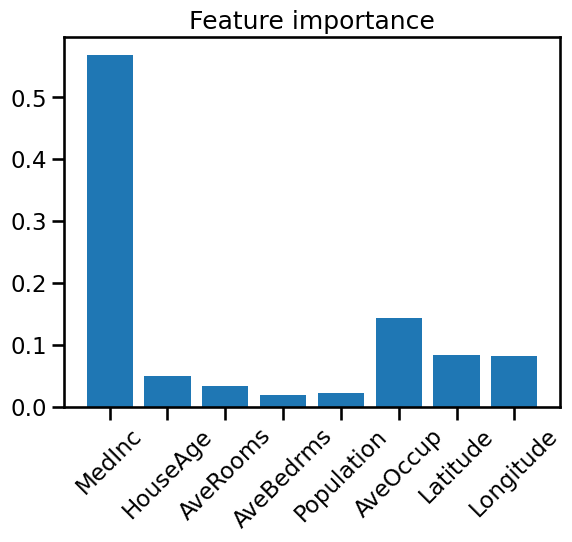

In [8]:
plt.bar(np.arange(0,len(housing.feature_names)),rf.feature_importances_)
plt.xticks(ticks=np.arange(0,len(housing.feature_names)),labels=housing.feature_names, rotation=45);
plt.title('Feature importance')
if figsave:
    plt.savefig('../fig/L2/importance_RF.png', bbox_inches='tight')

In [9]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators' : [100,400,800],
    'max_features' : [2, 4, 8],
    'min_samples_split' : [10,20,40]
}
clf = GridSearchCV(rf, param_grid, cv=3, verbose=2, n_jobs=4)

clf.fit(X,y)
print('GridSearch finished')

Fitting 3 folds for each of 27 candidates, totalling 81 fits
GridSearch finished


In [10]:
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for i, (mean, std, params) in enumerate(zip(means, stds, clf.cv_results_['params'])):
        if params['max_features']==8 and params['min_samples_split']==20 and params['n_estimators']==100:
            iref =i
            print('-->',end='')
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
      

0.798 (+/-0.008) for {'max_features': 2, 'min_samples_split': 10, 'n_estimators': 100}
0.798 (+/-0.008) for {'max_features': 2, 'min_samples_split': 10, 'n_estimators': 400}
0.798 (+/-0.009) for {'max_features': 2, 'min_samples_split': 10, 'n_estimators': 800}
0.788 (+/-0.010) for {'max_features': 2, 'min_samples_split': 20, 'n_estimators': 100}
0.787 (+/-0.011) for {'max_features': 2, 'min_samples_split': 20, 'n_estimators': 400}
0.788 (+/-0.010) for {'max_features': 2, 'min_samples_split': 20, 'n_estimators': 800}
0.770 (+/-0.008) for {'max_features': 2, 'min_samples_split': 40, 'n_estimators': 100}
0.771 (+/-0.010) for {'max_features': 2, 'min_samples_split': 40, 'n_estimators': 400}
0.771 (+/-0.010) for {'max_features': 2, 'min_samples_split': 40, 'n_estimators': 800}
0.796 (+/-0.009) for {'max_features': 4, 'min_samples_split': 10, 'n_estimators': 100}
0.797 (+/-0.011) for {'max_features': 4, 'min_samples_split': 10, 'n_estimators': 400}
0.797 (+/-0.011) for {'max_features': 4, 'm

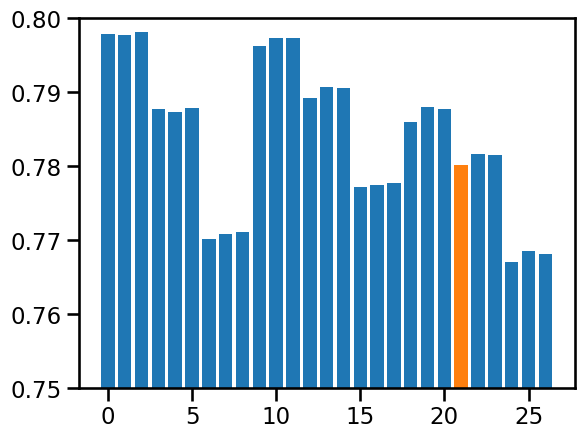

In [11]:
plt.bar(range(len(means)),means)
plt.bar(iref,means[iref])
plt.ylim(.75,.8)
plt.show()

In [12]:
report(clf.cv_results_)

print('Reference model')
print_score(clf.cv_results_,iref)

grid_best = best_score(clf.cv_results_)

Model with rank: 1
Mean validation score: 0.798 (std: 0.004)
Parameters: {'max_features': 2, 'min_samples_split': 10, 'n_estimators': 800}

Model with rank: 2
Mean validation score: 0.798 (std: 0.004)
Parameters: {'max_features': 2, 'min_samples_split': 10, 'n_estimators': 100}

Model with rank: 3
Mean validation score: 0.798 (std: 0.004)
Parameters: {'max_features': 2, 'min_samples_split': 10, 'n_estimators': 400}

Reference model
Mean validation score: 0.780 (std: 0.007)
Parameters: {'max_features': 8, 'min_samples_split': 20, 'n_estimators': 100}


In [13]:
from sklearn.model_selection import RandomizedSearchCV
param_dist = {
    'n_estimators' : [100,400,800],
    'max_features' : sp_randint(2,8),
    'min_samples_split' : sp_randint(10, 40)
}
clf = RandomizedSearchCV(rf, param_dist, cv=3, n_iter=15, 
                         verbose=2,n_jobs=4, random_state=1)

clf.fit(X,y)
print('Random finished')


Fitting 3 folds for each of 15 candidates, totalling 45 fits
Random finished


In [14]:
report(clf.cv_results_)
random_best = best_score(clf.cv_results_)

Model with rank: 1
Mean validation score: 0.799 (std: 0.004)
Parameters: {'max_features': 3, 'min_samples_split': 11, 'n_estimators': 100}

Model with rank: 2
Mean validation score: 0.795 (std: 0.004)
Parameters: {'max_features': 3, 'min_samples_split': 19, 'n_estimators': 400}

Model with rank: 3
Mean validation score: 0.795 (std: 0.005)
Parameters: {'max_features': 4, 'min_samples_split': 14, 'n_estimators': 400}



In [15]:
from hyperopt import tpe, hp, fmin, space_eval

#Define the objective function to minimize
def objective(params):
    n_estimators, max_features, min_samples_split = params['n_estimators'], params['max_features'], params['min_samples_split']
    rf = RandomForestRegressor(n_estimators=n_estimators, 
                           max_features=max_features, 
                           min_samples_split=min_samples_split,
                           random_state=10)
    score = cross_val_score(rf,X,y,cv = 3)

    return -score.mean()

In [16]:
space = {
    'n_estimators': hp.choice('n_estimators',[100,400,800]),
    'max_features': hp.randint('max_features',2,8),
    'min_samples_split' : hp.randint('min_samples_split',10,40
                                    )
}

In [17]:
best = fmin(
    fn=objective, # Objective Function to optimize
    space=space, # Hyperparameter's Search Space
    algo=tpe.suggest, # Optimization algorithm (representative TPE)
    max_evals=10 # Number of optimization attempts
)
print(space_eval(space,best))

100%|█████████████████████████████████████████████████| 10/10 [02:07<00:00, 12.80s/trial, best loss: -0.7947963075034625]
{'max_features': 2, 'min_samples_split': 12, 'n_estimators': 400}


In [18]:
best_params =space_eval(space,best)


In [19]:
rf = RandomForestRegressor(**best_params,
                           random_state=10)
score = cross_val_score(rf,X,y,cv = 3) #WARNING: THE SCORE HERE IS THE COEF OF DETERMINATION (GREATER IS BETTER)

[CV] END max_features=2, min_samples_split=10, n_estimators=400; total time=   3.1s
[CV] END max_features=2, min_samples_split=10, n_estimators=800; total time=   5.9s
[CV] END max_features=2, min_samples_split=20, n_estimators=800; total time=   5.5s
[CV] END max_features=2, min_samples_split=40, n_estimators=400; total time=   2.4s
[CV] END max_features=2, min_samples_split=40, n_estimators=800; total time=   4.9s
[CV] END max_features=4, min_samples_split=10, n_estimators=800; total time=  10.6s
[CV] END max_features=4, min_samples_split=20, n_estimators=400; total time=   4.8s
[CV] END max_features=4, min_samples_split=20, n_estimators=800; total time=   9.5s
[CV] END max_features=4, min_samples_split=40, n_estimators=800; total time=   8.7s
[CV] END max_features=8, min_samples_split=10, n_estimators=400; total time=   9.6s
[CV] END max_features=8, min_samples_split=10, n_estimators=800; total time=  19.0s
[CV] END max_features=8, min_samples_split=20, n_estimators=800; total time=

In [24]:
print('score: mean={:.3f} ; std={:.3f}'\
      .format(score.mean(),score.std()))
bayes_best = score.mean()

score: mean=0.799 ; std=0.004


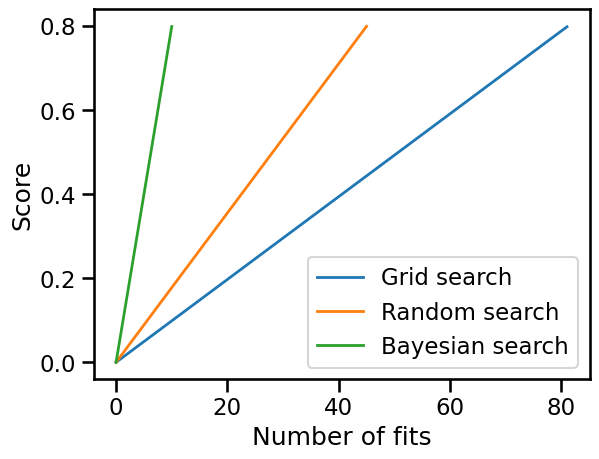

[CV] END max_features=2, min_samples_split=10, n_estimators=400; total time=   2.9s
[CV] END max_features=2, min_samples_split=10, n_estimators=800; total time=   5.7s
[CV] END max_features=2, min_samples_split=20, n_estimators=800; total time=   5.2s
[CV] END max_features=2, min_samples_split=40, n_estimators=400; total time=   2.3s
[CV] END max_features=2, min_samples_split=40, n_estimators=800; total time=   4.6s
[CV] END max_features=4, min_samples_split=10, n_estimators=800; total time=   9.7s
[CV] END max_features=4, min_samples_split=20, n_estimators=400; total time=   4.6s
[CV] END max_features=4, min_samples_split=20, n_estimators=800; total time=   9.1s
[CV] END max_features=4, min_samples_split=40, n_estimators=800; total time=   8.3s
[CV] END max_features=8, min_samples_split=10, n_estimators=400; total time=   9.1s
[CV] END max_features=8, min_samples_split=10, n_estimators=800; total time=  18.0s
[CV] END max_features=8, min_samples_split=20, n_estimators=800; total time=

In [27]:
plt.plot([0,81], [0, grid_best],linewidth=2, label='Grid search')
plt.plot([0,45], [0, random_best],linewidth=2, label='Random search')
plt.plot([0,10], [0, bayes_best],linewidth=2, label='Bayesian search')
plt.xlabel('Number of fits')
plt.ylabel('Score')
plt.legend()